In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
%matplotlib inline
import xml.etree.ElementTree as ET
import re
import pprint
import unicodedata
import codecs
import json
from collections import defaultdict
# for plotting
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns


# Mongo DB data wrangling

In this document we are going to analyse the OSM dataset for Madrid , the dataset has been downloaded from :

https://mapzen.com/data/metro-extracts/metro/madrid_spain/101748283/Madrid/

Madrid is my home town so the spotting errors in the dataset should be easier. The dataset covers the whole province of Madrid but as it is defined as an square area in also includes some features of the neighbour provinces which are:

- Toledo
- Avila
- Segovia
- Guadalajara
- Cuenca

We need to take this into account when analysing the dataset.

![img](map.png)

For this analysis I have choose MongoDB as the database. 

## Problems encountered in the map

After generating a reduced dataset with a 10th of the records.We proceed with the initial assessment of the data using a reduced dataset, the following fields have been analysed:

- street names
- leisures
- amenities
- postal codes

We haved generated a sample file with a 10th of the values for the data wrangling analysis usgin the following script:

create_sample_from_osm.py

this script will also generate a sample with a 100th of the data more suitable for upload.

Based on this analysis some filtering or cleaning functions will be generated in order to clean the error encountered in the data.


### Street names

First we are going to clean the street names, so we will modify street abbreviations into the full name in order to have consistent street definitions across the dataset. We have to take into account that in spanish, contrary to english, the type of street is the first word. Finally we will use lower case in order to simplify the analysis.

We can find both abbreviations such as:
- Av and Avd instead of Avenida (Avenue)
- Pz instead of Plaza (Square)

and typos such as:
- 'Call' instead of 'calle' (street)
- 'carrera' instead of 'carretera' (Road), however "carrera" is a valid street type, this kind of errors can be easily missed, two of these cases have been found : 'CARRERA': set([u'CARRERA CARRETERA DE CRI\xd1ON, S/N', 'CARRERA VALENCIA, KM 14.800'])})

Spanish roads use a common nomenclarture : a set of letters followed by a number e.g. A-6 M-604, we can match these entries using a regexp and add them to the type "carretera" (road). Assuming that we are using lowercase name we can use the folloing regexp

```
    /[a-z]+\-[0-9]+/
```

Some fields are preceded by "CL" and then a valid address type, in these cases whe should remove the leading "CL". e.g. "CL AVENIDA" should be "avenida" (avenue).

The most common error is the use of streets names withouth the street identifier, so we will by default add street and the begining of these entries.

Next we found that C.N.-603-MARGEN should be "carretera n-603". Therefore we will change "C.N." into "carretera n-"

Another problem found was the presence of accented words, so in order to simplify the further analysis we will remove the accents of the words. e.g. we will use "travesia" instead of the gramatically correct "travesía", as this will simplify our database handling as well as filtering some errors in the inputs.


In [2]:
SAMPLE_FILE = "sample.osm"

street_type_re = re.compile(r'^\S+(\b|\.)', re.IGNORECASE)

expected_street_type = ["calle","avenida","plaza","paseo","pasaje","ronda","travesia",
            "costanilla","callejon","camino","carretera","bulevar","autovia",
            "rinconada", "glorieta","urbanizacion","senda","poligono","finca"]

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type.lower() not in expected_street_type:
            street_types[street_type].add(street_name)


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(osmfile, is_type, audit_type , filter_fun = lambda x : x):
    osm_file = open(osmfile, "r")
    list_types = defaultdict(set)
    leisure_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_type(tag):
                    # check that there is the required value element
                    if not "v" in tag.attrib:
                        print tag
                    value = tag.attrib['v']
                    audit_type(list_types, filter_fun(value)) 
    osm_file.close()
    return list_types

street_types = audit(SAMPLE_FILE,is_street_name,audit_street_type)

pprint.pprint( dict(street_types))



{'A-6': set(['A-6 KM 25.5']),
 'AVDA': set(['AVDA DEL VALLE 36 (CRTA M 604 KM 24.100)',
              u'AVDA. DEL ANTIG\xdcO FERROCARRIL, N\xba 1',
              'AVDA. PUERTA DE MADRID']),
 'Albert': set(['Albert Amon']),
 'Antonio': set(['Antonio Buero Vallejo']),
 u'Auditorio': set([u'Auditorio Sebasti\xe1n Cesteros']),
 u'Autov\xeda': set([u'Autov\xeda de Toledo', u'Autov\xeda de Toledo A-42']),
 'Av': set(['Av. del Doce de Octubre']),
 'Avda': set(['Avda de Covibar']),
 'Bajada': set(['Bajada de San Juan de los Reyes']),
 'Barrio': set(['Barrio de San Luis']),
 u'C': set([u'C/ Jos\xe9 Bergam\xedn']),
 'C.N.-603-MARGEN': set(['C.N.-603-MARGEN DERECHO km 93.60000']),
 'CARRERA': set([u'CARRERA CARRETERA DE CRI\xd1ON, S/N',
                 'CARRERA VALENCIA, KM 14.800']),
 'CL': set(['CL AVDA. S. MARTIN DE VALDEIGLE, S. (M-501 KM 0.3)',
            'CL AVENIDA CASTILLA LA MANCHA, 79 (N-401 KM 35.5)',
            'CL CARRETERA ARANJUEZ ,56 (CR M-305 (M-305 KM 19.8)']),
 'CL-605': set

In [3]:
# Filtering of the addreses
mapping = { "call":"calle",
            "c/":"calle",
            "ctra.":"carretera",
            "cr":"carretera",
            "calleja/callejon":"callejon",
            "urb.":"urbanizacion",
            "urb":"urbanizacion",
            "Pz":"plaza",
            "Pz.":"plaza",
            "av": "Avenida",
            "avd": "avenida",
            "avd.": "avenida",
            "pasaje/pasadizo":"pasaje",
            "av.": "avenida",
            "rcda.":"rinconada",
            "CARRERA CARRETERA":"carretera",
            "CARRERA VALENCIA":"carrera"
            }
# this function return a function that updates a name based on the mappings input only for the first word
def get_update_first_word_filter(mapping):
    def update_name(name):
        words = name.split()
        if words[0] in mapping:
            words[0] = mapping[words[0]]
        name = " ".join(words)
        return name
    return update_name

def set_default_street(name):
    words = name.split()
    if words[0] not in expected_street_type:
        name = "calle "+ name
    return name

# remove accent function, obtained from stackoverflow 
# http://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-in-a-python-unicode-string
def strip_accents_filter(name):
   name = unicode(name)
   return ''.join(c for c in unicodedata.normalize('NFD', name) if unicodedata.category(c) != 'Mn')

def lower_name_filter(name):
    return name.lower()

def remove_leading_CL_filter(name):
    if name.startswith("CL "):
        name = name[3:]
    return name

def change_cr_filter(name):
    if name.startswith("C.N."):
        name = "carretera n-"+name[4:]
    return name


ROAD_RE = re.compile(r'[a-z]+\-[0-9]+', re.IGNORECASE)

def identify_road_filter(name):
    if ROAD_RE.match(name):
        name = "carretera "+name
    return name
    
# this function applies a series of transformations or filters to an initial value
def gen_apply_filters(filters):
    def filter_function(value):
        temp = value
        for function in filters:
            temp = function(temp)
        return temp
    return filter_function


# build list of functions that we will apply to clean our street address
FILTER_STREET = gen_apply_filters([remove_leading_CL_filter,change_cr_filter, 
                                  lower_name_filter, strip_accents_filter,
                                  get_update_first_word_filter(mapping), set_default_street])



### Leisures

We want also to check for kind of leisures are available and clean those fields. As we would like to make queries related with the number of green places in the city.

From the list above we can appreciate that there are no big issues in this list, for our purpouse we could consider both "park" and "natural reserve". We can observe that the entries for "leisures" are in english, but for the "pista de cemento" (cement pitch), fortunately this is not affecting our analysis so we are not going to modify these fields.

Nevertheless, the fields can be considered to be uniquely identified either in spanish or english, so we can keep them as they are as there is not any kind of leisure that is described in both languages at the same time.


In [4]:
expected_leisures = ["park","natural_reserve"]

def audit_leisure_type(leisure_types, leisure_name):
    if leisure_name:
        if leisure_name.lower() not in expected_leisures:
            leisure_types[leisure_name].add(leisure_name)


def is_leisure(elem):
    return (elem.attrib['k'] == "leisure")

leisure_types = audit(SAMPLE_FILE,is_leisure,audit_leisure_type)

# show the types of leisures in the sample file
pprint.pprint( dict(leisure_types))

{'bandstand': set(['bandstand']),
 'casino': set(['casino']),
 'common': set(['common']),
 'dance': set(['dance']),
 'dog_park': set(['dog_park']),
 'dog_track': set(['dog_track']),
 'fishing': set(['fishing']),
 'fitness_station': set(['fitness_station']),
 'garden': set(['garden']),
 'golf_course': set(['golf_course']),
 'marina': set(['marina']),
 'miniature_golf': set(['miniature_golf']),
 'music_venue': set(['music_venue']),
 'nature_reserve': set(['nature_reserve']),
 'picnic_table': set(['picnic_table']),
 'pista de cemento': set(['pista de cemento']),
 'pitch': set(['pitch']),
 'playground': set(['playground']),
 'recreation_ground': set(['recreation_ground']),
 'sports_centre': set(['sports_centre']),
 'stadium': set(['stadium']),
 'swimming_pool': set(['swimming_pool']),
 'track': set(['track'])}


### Amenities

We want also to check what kind of amenities are available and clean those fields.

Unlike for leisures in amenities we can find that the same amenity is defined in some cases in spanish and some times in english, for example:

- "biblioteca" and "library"
- "espacio_trabajo" and "coworking_space"

It is convenient to use an unique language for the amenities definitions. Therefore, we will translate these entries into english.


In [5]:
expected_amenities = []

def audit_amenities_type(amenities_types, amenities_name):
    if amenities_name:
        if amenities_name.lower() not in expected_amenities:
            amenities_types[amenities_name].add(amenities_name)


def is_amenities(elem):
    return (elem.attrib['k'] == "amenity")

amenities_types = audit(SAMPLE_FILE,is_amenities,audit_amenities_type)

# show the types of leisures
pprint.pprint( sorted(amenities_types.keys()))

[u'Fontaner\xeda',
 'Locutorio',
 'arts_centre',
 'atm',
 'aula',
 'bank',
 'bar',
 'bench',
 'biblioteca',
 'bicycle_parking',
 'bicycle_rental',
 'biergarten',
 'brothel',
 'bus_station',
 'cafe',
 'car_rental',
 'car_wash',
 'casino',
 'childcare',
 'cinema',
 'clinic',
 'college',
 'common',
 'community_centre',
 'court_yard',
 'courthouse',
 'coworking_space',
 'dentist',
 'despacho',
 'doctors',
 'drinking_water',
 'driving_school',
 'embassy',
 'espacio de trabajo',
 'fast_food',
 'fire_station',
 'first_aid',
 'food_court',
 'fountain',
 'fuel',
 'gambling',
 'garden',
 'grave_yard',
 'hospital',
 'ice_cream',
 'internet_cafe',
 'kindergarten',
 'language_school',
 'library',
 'marketplace',
 'monastery',
 'mortuary',
 'motorcycle_parking',
 'music_venue',
 'nightclub',
 'parking',
 'parking_entrance',
 'parking_space',
 'pharmacy',
 'photo_booth',
 'place_of_worship',
 'police',
 'post_box',
 'post_office',
 'pub',
 'public_bookcase',
 'public_building',
 'recycling',
 'regist

In [6]:
# Filtering of the addreses
mapping_ammenity = { "biblioteca" :"library",
            "espacio_trabajo" : "coworking_space"
            }

# build list of functions that we will apply to clean our street address
FILTER_AMENITY = gen_apply_filters([get_update_first_word_filter(mapping_ammenity)])

### Postal codes

The postal codes in spain consist of 5 numbers, of which the 2 first depend on the provinces, as we have 6 provinces in opur dataset, we can find 6 sets of postal codes:

- Madrid: 28XXX
- Toledo: 45XXX
- Avila: 05XXX
- Segovia: 40XXX
- Guadalajara: 19XXX
- Cuenca: 16XXX

Therefore we can build a regexp to filter those postal codes that do not match one of the above. Using this approach we can see that there are postal codes that have not been properly set, for instance using 4 or 6 digits, in other cases there is a letter in the postal code or an invalid separator such as "-".

In order to have a clean dataset we will remove these entries.

In [7]:
CP_RE = re.compile("^(28|45|05|40|19|16)[0-9]{3}$")

def audit_cp_type(cp_types, postcode):
    if postcode:
        if not CP_RE.match(postcode):
            cp_types[postcode].add(postcode)


def is_cp(elem):
    return (elem.attrib['k'] == "addr:postcode")

postcode_types = audit(SAMPLE_FILE,is_cp,audit_cp_type)

# show the incorrect postcodes
print("Unexpected postcodes")
pprint.pprint( dict(postcode_types))

Unexpected postcodes
{'21-23': set(['21-23']),
 '2829': set(['2829']),
 '2839': set(['2839']),
 '288981': set(['288981']),
 '2945': set(['2945']),
 'E28016': set(['E28016'])}


In [8]:
# data cleaning function for postcode
def remove_invalid_postcode(postcode):
    if CP_RE.match(postcode):
        return postcode
    else:
        return None

FILTER_POSTCODE = gen_apply_filters([remove_invalid_postcode])

Next, we are going to load our XML data into a more appropiate object representation that will be loaded into a JSON file in order to import it into the final mongoDB database. For this task we will use the python file create_json_from_osm.py , executing it from the command line.

### Load into Mongo DB

We then import this dataset into mongodb using the mongoimport function.

```
mongoimport --db cities --collection madrid --file madrid_spain.osm.json
```

## Data overview

This section contains basisc statistics about the dataset and the MongoDB database.

Size of the files:

- madrid_spain.osm : 858MB 
- madrid_spain.osm.json : 962MB 
- Number of documents in the database: 4,498,329

Data realted to the users:

- number of unique users: 2579

### Unique users

We can see how many user have contributed to this dataset and which are the most actives ones:

In [9]:
def get_db(db_name):
    from pymongo import MongoClient
    client = MongoClient('localhost:27017')
    db = client[db_name]
    return db

db_madrid = get_db("cities").madrid

pprint.pprint(len(db_madrid.distinct("created.uid")))

2579


### Number of documents

In [10]:
result = db_madrid.find().count()
pprint.pprint(result)

4498329


### Number of nodes
We can observe that this is the main kind of document accounting for 89% of the total documents in the database.

In [11]:
result = db_madrid.find({"type":"node"}).count()
pprint.pprint(result)

3993760


### Number of ways

In [12]:
result = db_madrid.find({"type":"way"}).count()
pprint.pprint(result)

504110


### Top postcodes 

In [13]:
result = [doc for doc in db_madrid.aggregate([{"$match":{"address.postcode":{"$exists":1}}}, 
                                       {"$group":{"_id":"$address.postcode", "count":{"$sum":1}}}, 
                                       {"$sort":{"count":-1}},{"$limit":10}])]
pprint.pprint(result)

[{u'_id': u'28330', u'count': 5252},
 {u'_id': u'28300', u'count': 3968},
 {u'_id': u'28017', u'count': 3531},
 {u'_id': u'28970', u'count': 3135},
 {u'_id': u'28830', u'count': 2709},
 {u'_id': u'28030', u'count': 2620},
 {u'_id': u'28004', u'count': 1990},
 {u'_id': u'28180', u'count': 1884},
 {u'_id': u'28012', u'count': 1727},
 {u'_id': u'28007', u'count': 1414}]


From the results above we can see that the postcode 28330 is the one with more nodes identified, it we take a look at the area in the map we can observe that this is a big but rather unpopulated area in the outskirts of Madrid.

![img](area28330.png)

So how is that this postcode is so popular in our database? maybe a very active user lives there. So we can list the users that populate nodes in that area. From this query we can see that most of the records in this area (95%) have been created by the user 3196761. 

Thanks to that user this area is well populated.

In [14]:
result = [doc for doc in db_madrid.aggregate([{"$match":{"address.postcode":'28330',
                                                         "created.uid":{"$exists":1}}}, 
                                       {"$group":{"_id":"$created.uid", 
                                                  "count":{"$sum":1}}}, 
                                       {"$sort":{"count":-1}}])]
pprint.pprint(result)

[{u'_id': u'3196761', u'count': 4992}, {u'_id': u'2240612', u'count': 260}]


### Number of documents with an street field

In [15]:
result =  [doc for doc in db_madrid.find({"address.street":{"$exists":1}})]
pprint.pprint(len(result))

67757


### Number of adresses with no postcode or invalid one

In [16]:
result = [doc for doc in db_madrid.aggregate([{"$match":{"address.street":{"$exists":1}}}, 
                                       {"$group":{"_id":"$address.postcode", "count":{"$sum":1}}}, 
                                       {"$match":{"_id":None}}])]
pprint.pprint(result[0]["count"])

15279


### Most popular amenities

In [17]:
result = [doc for doc in db_madrid.aggregate([{"$match":{"amenity":{"$exists":1}}}, 
                                       {"$group":{"_id":"$amenity", "count":{"$sum":1}}}, 
                                       {"$sort":{"count":-1}},{"$limit":10}])]
pprint.pprint(result)

[{u'_id': u'parking', u'count': 5513},
 {u'_id': u'restaurant', u'count': 3715},
 {u'_id': u'school', u'count': 3316},
 {u'_id': u'pharmacy', u'count': 2229},
 {u'_id': u'drinking_water', u'count': 2225},
 {u'_id': u'bank', u'count': 1723},
 {u'_id': u'bar', u'count': 1434},
 {u'_id': u'bench', u'count': 1406},
 {u'_id': u'recycling', u'count': 1360},
 {u'_id': u'bicycle_parking', u'count': 1238}]


### Most popular leisures

In [18]:
result = [doc for doc in db_madrid.aggregate([{"$match":{"leisure":{"$exists":1}}}, 
                                       {"$group":{"_id":"$leisure", "count":{"$sum":1}}}, 
                                       {"$sort":{"count":-1}},{"$limit":10}])]
pprint.pprint(result)

[{u'_id': u'garden', u'count': 8180},
 {u'_id': u'pitch', u'count': 6302},
 {u'_id': u'swimming_pool', u'count': 5542},
 {u'_id': u'park', u'count': 3507},
 {u'_id': u'playground', u'count': 2029},
 {u'_id': u'sports_centre', u'count': 881},
 {u'_id': u'common', u'count': 246},
 {u'_id': u'track', u'count': 144},
 {u'_id': u'stadium', u'count': 89},
 {u'_id': u'dog_park', u'count': 62}]


### Street of type "calle"

In [19]:
result = [doc for doc in db_madrid.aggregate([
                                      {"$match":{"address.street":{"$exists":1, "$regex": '^calle'}}},
                                      {"$group":{"_id":"calle", "count":{"$sum":1}}},
                                      {"$sort":{"count":1}}])]
pprint.pprint(result[0]["count"])

57009


### Most active users

We can observer that the most active user accounts for the 10% of all the contributions.

In [20]:
result = [doc for doc in db_madrid.aggregate([{"$match":{"created.uid":{"$exists":1}}},
                                      {"$group":{"_id":"$created.uid", 
                                                 "name": { "$addToSet": "$created.user" } ,
                                                 "count":{"$sum":1}}},
                                      {"$sort":{"count":-1}},
                                      {"$limit":10}])]

pprint.pprint(result)

[{u'_id': u'718437', u'count': 452285, u'name': [u'carlosz22']},
 {u'_id': u'468314', u'count': 350368, u'name': [u'rafaerti']},
 {u'_id': u'2245342', u'count': 260589, u'name': [u'cirdancarpintero']},
 {u'_id': u'777223', u'count': 194528, u'name': [u'Serfuen']},
 {u'_id': u'491515', u'count': 162791, u'name': [u'robertogeb']},
 {u'_id': u'33103', u'count': 150752, u'name': [u'sergionaranja']},
 {u'_id': u'3196761', u'count': 149092, u'name': [u'JavierSp']},
 {u'_id': u'436572', u'count': 141117, u'name': [u'Pelanas']},
 {u'_id': u'2500', u'count': 135641, u'name': [u'jamesks']},
 {u'_id': u'3584', u'count': 131142, u'name': [u'gpesquero']}]


We can see in the following histogram how users are distributed for those with less than 100 contributions.

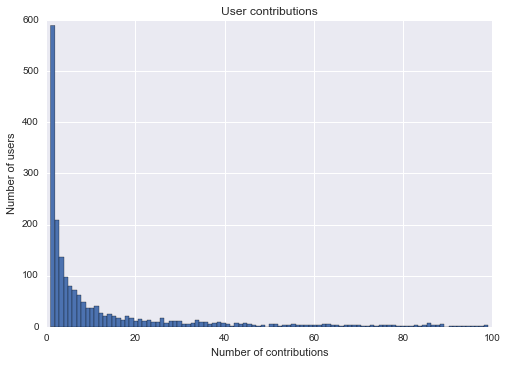

In [21]:
result = [doc for doc in db_madrid.aggregate([{"$match":{"created.uid":{"$exists":1}}},
                                      {"$group":{"_id":"$created.uid", 
                                                 "name": { "$addToSet": "$created.user" } ,
                                                 "count":{"$sum":1}}},
                                      {"$match":{"count":{"$lt":100}}},
                                      {"$sort":{"count":-1}}])]

y = [x["count"] for x in result]
plt.hist( y,100)
plt.title("User contributions")
plt.xlabel('Number of contributions')
plt.ylabel('Number of users')
plt.show()

### Number of green spaces

In [22]:
result =  db_madrid.find({"leisure":{"$in":["park","natural_reserve","garden"]}}).count()
pprint.pprint(result)

11688


## Additional ideas

In this dataset the address field uses the spanish labeling whereas most leisure data use english, it would be interesting to use a common language e.g. English. However, programmatic translations are not an easy task and can lead to other errors, especially when different languages are used in a same dataset where false friend may cause tranlation errors for example.

It would also be interesting to assess the closeness of some nodes to others for example, which bars are within 200m of a park? but this kind of queries are not stright forward to perform using MongoDB or an SQL database, maybe a graph database may help in this task.

Also wrong postcodes could be corrected using the address in order to obtain the postcode using a third party API that relates addresses with postcodes.

From the analysis of the contributions in the postcode 28330 area we can see how important are active users in order to have quality data in an area. One question that can arise from this observation is to quantify the quality of the data provided by the users. for e.g. we can ask,  which users provide postcodes in their inputs? As in the query below, and we can observed that although the top contributor remains 'carlosz22' we can see that 'JavierSp' is now second, this is the user that contributed to the postcode 28330 area. a further analysis could be to see how the users contribute to different areas for example using the postcodes as references.


In [23]:
result = [doc for doc in db_madrid.aggregate([{"$match":{"created.uid":{"$exists":1},
                                                         "address.postcode":{"$exists":1}}},
                                      {"$group":{"_id":"$created.uid" ,
                                                 "count":{"$sum":1}}},
                                      {"$sort":{"count":-1}},
                                      {"$limit":10}])]

pprint.pprint(result)

[{u'_id': u'718437', u'count': 8454},
 {u'_id': u'3196761', u'count': 4995},
 {u'_id': u'1334676', u'count': 3785},
 {u'_id': u'2277975', u'count': 3655},
 {u'_id': u'777223', u'count': 3232},
 {u'_id': u'2295186', u'count': 3108},
 {u'_id': u'2019603', u'count': 3073},
 {u'_id': u'1773299', u'count': 2952},
 {u'_id': u'1877329', u'count': 1920},
 {u'_id': u'220932', u'count': 1684}]


Another question we could make is to see who are the contributors that have set more number of different postcodes. i.e the contributors to more different areas in Madrid. We can see that the top user in this list has contributed to more than 100 areas, a great traveller.

In [24]:
result = [doc for doc in db_madrid.aggregate([
                                      {"$match":{"created.uid":{"$exists":1},
                                                 "address.postcode":{"$exists":1}}},
                                      {"$group":{"_id":"$created.uid", 
                                                 "postcodes": { "$addToSet": "$address.postcode" } ,
                                                 "count":{"$sum":1}}},
                                      {"$unwind":"$postcodes"},
                                      {"$group":{"_id":"$_id","count":{"$sum":1}}},
                                      {"$sort":{"count":-1}},
                                      {"$limit":10}])]

pprint.pprint(result)


[{u'_id': u'220932', u'count': 101},
 {u'_id': u'316694', u'count': 77},
 {u'_id': u'2153421', u'count': 70},
 {u'_id': u'26599', u'count': 64},
 {u'_id': u'42055', u'count': 57},
 {u'_id': u'718437', u'count': 51},
 {u'_id': u'2403132', u'count': 51},
 {u'_id': u'4647806', u'count': 41},
 {u'_id': u'2245342', u'count': 40},
 {u'_id': u'1068293', u'count': 38}]


It can be interest to see how different areas compare, for example we can which areas have more restaurants. However it should be taken into account thath not all areas are equal in size. and that some areas might not be well populated with data.

In [25]:
result = [doc for doc in db_madrid.aggregate([{"$match":{"amenity":"restaurant","address.postcode":{"$exists":1}}}, 
                                       {"$group":{"_id":"$address.postcode", "count":{"$sum":1}}}, 
                                       {"$sort":{"count":-1}},{"$limit":10}])]
pprint.pprint(result)

[{u'_id': u'28004', u'count': 219},
 {u'_id': u'28013', u'count': 192},
 {u'_id': u'28015', u'count': 139},
 {u'_id': u'28012', u'count': 111},
 {u'_id': u'28005', u'count': 71},
 {u'_id': u'28020', u'count': 42},
 {u'_id': u'28008', u'count': 40},
 {u'_id': u'28010', u'count': 36},
 {u'_id': u'28006', u'count': 30},
 {u'_id': u'28001', u'count': 28}]


Another interesting analysis would be to compare the different top amenities in difference places, for example how the number of schools compare between different cities, etc.. This will imply a very large dataset and take into account other data in order to normalize the values e.g. schools per person.

## Conclusion

After the review of the dataset it is clear that there are typos in the manual inputs even for postcodes that are easy to validate during the input phase, maybe it would be nice to have some schema and field validation when users incorporate data into the OSM dataset. 

Furthermore, we can see that the language may impact the dataset as some fields tend to be filled in the local language whereas others such as the kind of leisure tend to be filled in english although it is not always the case and some field have mixed inputs which may difficult querying the database for users not familiar with the local language.

Finally, we can see that some areas are more complete and this seems to be highly related to the active users in that area, so it would be nice to have a way to incentivate or recompensate more active users, for example with badgets or lists of top users. This is important because the quality of the data depends directly on the users.

